In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.myfunctions as mf
from dask.diagnostics import ProgressBar

# Labor Capacity Function

In [42]:
def capacity(ds,population,region,ax):
    # Get yearly capacity data for grid cells in region
    ds_region = mf.slice_region(ds,region)
    
    # Get weighted area for grid cells
    pop_region = mf.slice_region(population,region)
    pop_weights = pop_region/pop_region.sum(['lat','lon'])
    
    # Calculate total area-weighted capacity per year
    capacity = (ds_region*pop_weights).sum(['lat','lon'])
    
    # Loop through ensemble members
    for ens in capacity['ensemble']:
        capacity.sel(ensemble=ens).plot(ax=ax,color='royalblue',alpha=0.25)

    # Ensemble average labor capacity
    capacity_avg = capacity.mean(dim='ensemble')
    capacity_avg.plot(ax=ax,color='royalblue',linewidth=2)
    ax.set_xlabel('Year')
    ax.set_ylabel('Labor Capacity, %')
    ax.set_title(region)

In [16]:
# Load labor productivity data
ds = xr.open_dataset('../data/processed/labor_productivity.nc').rename({'WBT':'capacity'})

In [29]:
# Population data
ds_pop = xr.open_dataset('../data/processed/population_regrid.nc')['population']
ds_pop = ds_pop.where(np.isfinite(ds_pop),0)
ds_pop = ds_pop.rename({'latitude':'lat','longitude':'lon'})

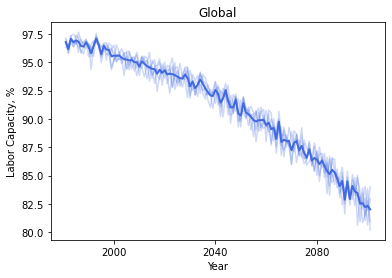

In [47]:
fig,ax = plt.subplots()
capacity(ds['capacity'],ds_pop,'Global',ax)

# Plots for Regions

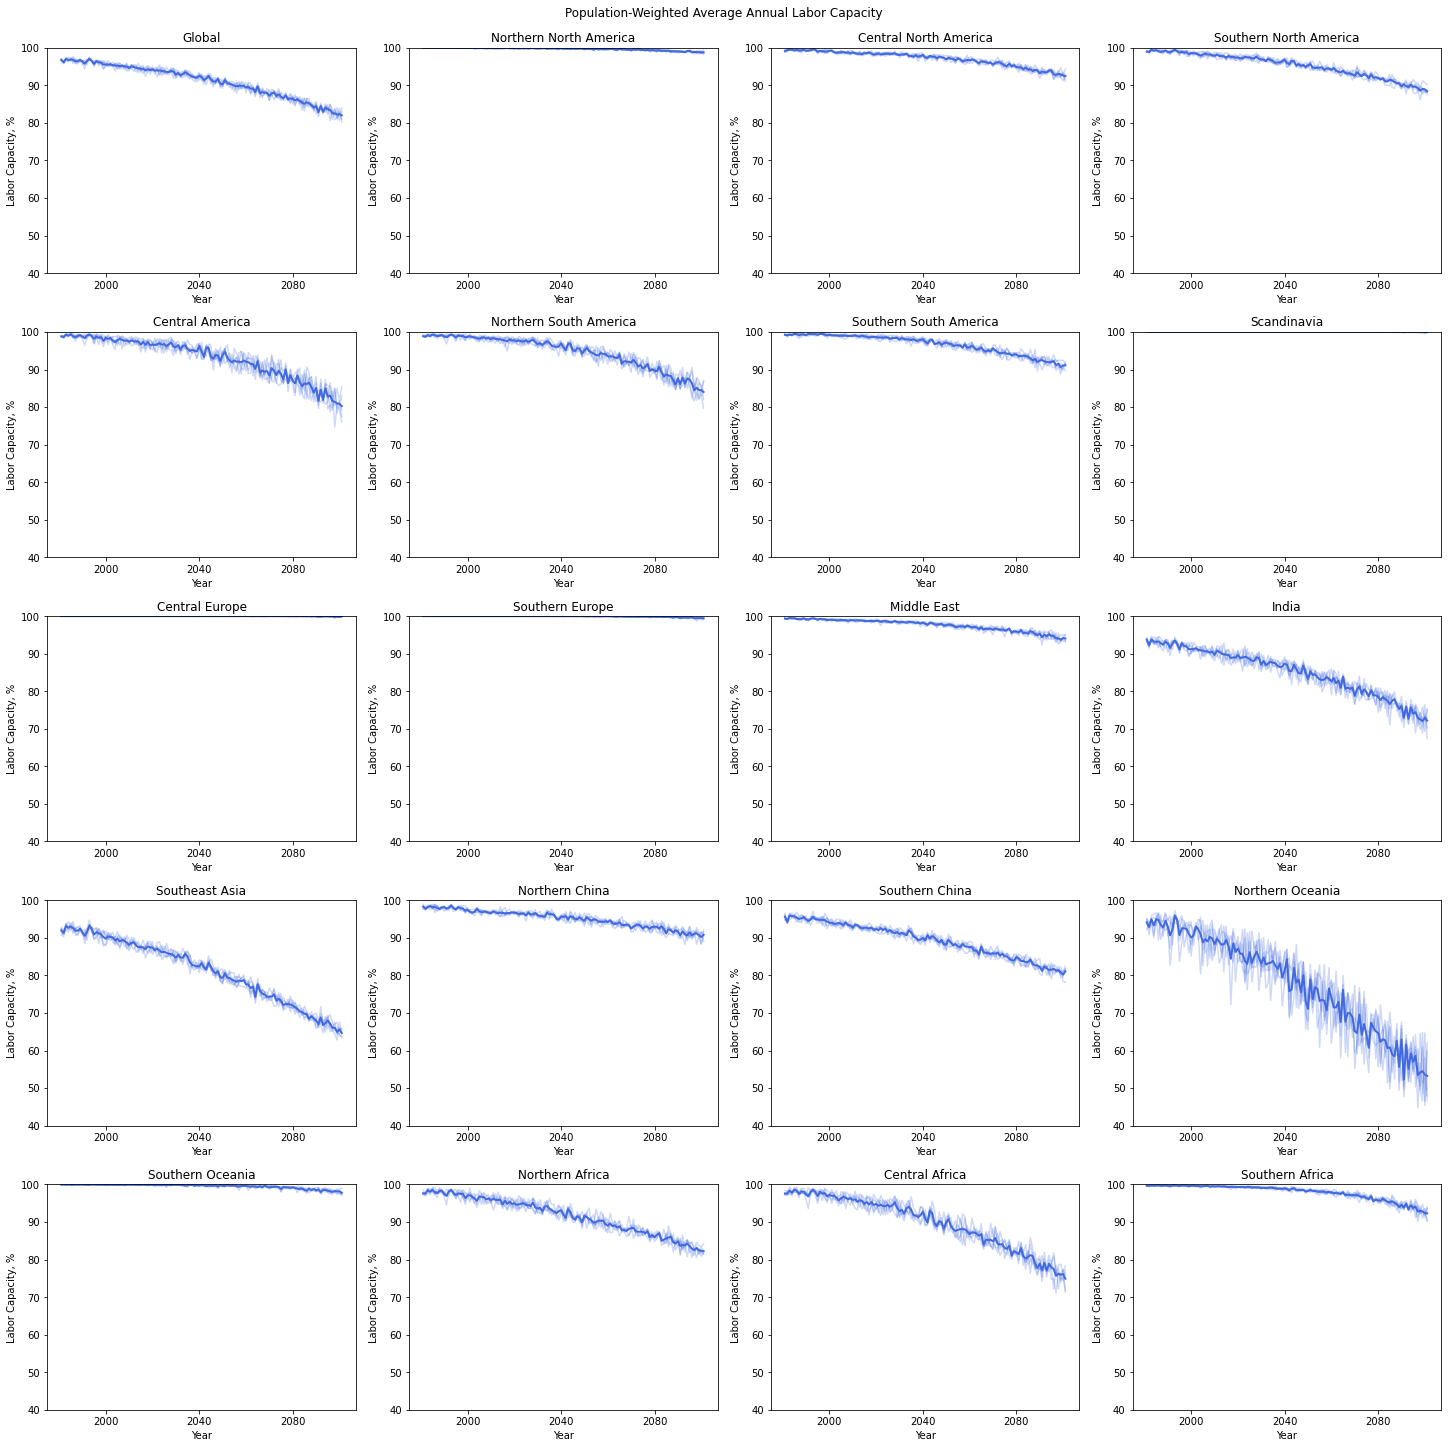

In [51]:
regions = ['Global','Northern North America','Central North America','Southern North America',
          'Central America','Northern South America','Southern South America',
          'Scandinavia','Central Europe','Southern Europe',
          'Middle East','India','Southeast Asia','Northern China','Southern China',
          'Northern Oceania','Southern Oceania',
          'Northern Africa','Central Africa','Southern Africa']

# Create figure and axes
fig, axs = plt.subplots(figsize=(20,20),nrows=5,ncols=4,constrained_layout=True)

# Running counter to determine axis
index = 0

# Loop through regions
for region in regions:
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    index+=1
    
    capacity(ds['capacity'],ds_pop,region,ax)
    ax.set_ylim([40,100])
fig.suptitle('Population-Weighted Average Annual Labor Capacity');

# Global Visualization

In [7]:
# Load labor productivity data
ds = xr.open_dataset('../data/processed/labor_productivity.nc').rename({'WBT':'capacity'})

In [5]:
# Load area data
land_area = xr.open_dataset('../data/processed/wbt.land_area')
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0).rename({'__xarray_dataarray_variable__':'land_area'})

In [13]:
region = 'India'
ds_region = mf.slice_region(ds,region)
area_region = mf.slice_region(land_area_adj,region)
area_weights = area_region/area_region.sum(['lat','lon'])

capacity = (ds_region['capacity']*area_weights).sum(['lat','lon'])['land_area']

Text(0, 0.5, 'Labor Capacity, %')

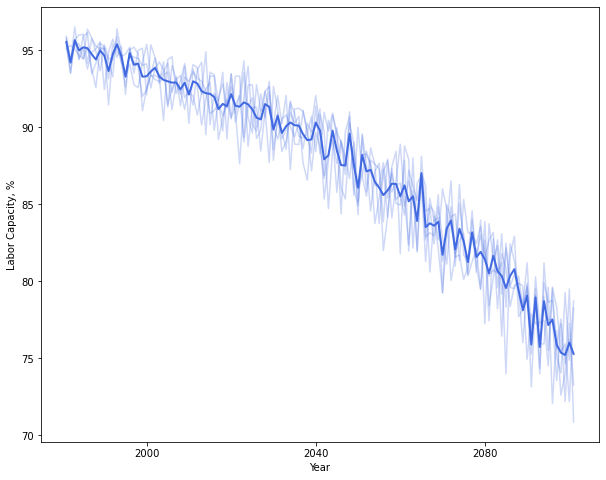

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
for ens in capacity['ensemble']:
    capacity.sel(ensemble=ens).plot(ax=ax,color='royalblue',alpha=0.25)
    
capacity_avg = capacity.mean(dim='ensemble')
capacity_avg.plot(ax=ax,color='royalblue',linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Labor Capacity, %')

# Global Scale Data

In [2]:
# Load WBT data
ds = xr.open_mfdataset('../data/processed/WBTdaily/WBTdailyens*.nc',combine='nested',concat_dim='ensemble',chunks={'time':1095})

In [8]:
ds_daily = 100 - 25*((ds['WBT']-25)**(2/3))
ds_daily = ds_daily.where(np.isfinite(ds_daily),100)

In [10]:
ds_yearly = ds_daily.resample(time='1Y').mean()

# Data Processing

In [2]:
# Load WBT data
ds = xr.open_mfdataset('../data/processed/WBTdaily/WBTdailyens*.nc',combine='nested',concat_dim='ensemble',chunks={'lat':10,'lon':10})

In [4]:
# Get WBT data for a single grid cell
ds_small = ds.sel(lat=19,lon=72,method='nearest')['WBT']

In [6]:
with ProgressBar():
    ds_small.to_netcdf('../data/processed/labor_test.nc')

[########################################] | 100% Completed | 23min 46.9s


# Processed Data

In [15]:
ds = xr.open_dataset('../data/processed/labor_test.nc')

In [19]:
ds_adj = ds.where(ds>25,25)
ds_daily = 100 - 25*((ds_adj-25)**(2/3))

In [21]:
ds_yearly = ds_daily.resample(time='1Y').mean()

Text(0, 0.5, 'Labor Capacity, %')

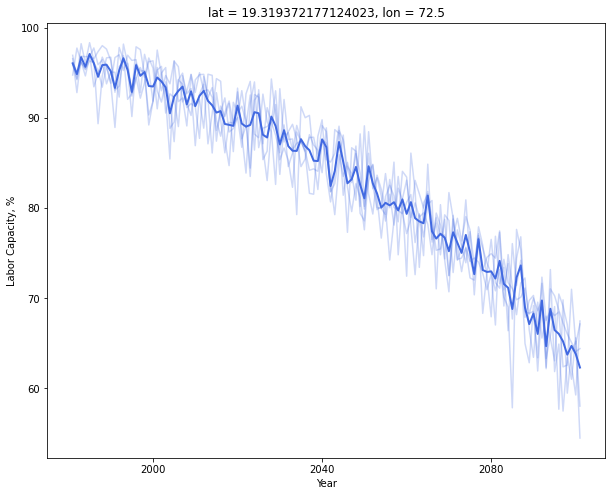

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
for ens in ds_yearly['ensemble']:
    ds_yearly.sel(ensemble=ens)['WBT'].plot(ax=ax,color='royalblue',alpha=0.25)
    
ds_avg = ds_yearly.mean(dim='ensemble')
ds_avg['WBT'].plot(ax=ax,color='royalblue',linewidth=2)
ax.set_xlabel('Year')
ax.set_ylabel('Labor Capacity, %')

# Test With Histogram Data

In [37]:
ds = xr.open_dataset('../data/processed/WBT_binned.nc')

In [71]:
region = 'India'
ds_region = ds[region]

In [97]:
# Calculate labor capacity using formula
ds_region_adj = ds_region.assign_coords({'capacity':(100 - 25*((ds_region['WBT_bin']-25)**(2/3)))})

# For WBT < 25, assign capacity = 100
ds_region_adj = ds_region_adj.assign_coords({'capacity':ds_region_adj['capacity'].where(np.isfinite(ds_region_adj['capacity']),100)})

# For WBT > 33, assign capacity = 0
ds_region_adj = ds_region_adj.assign_coords({'capacity':ds_region_adj['capacity'].where(ds_region_adj['capacity']>0,0)})

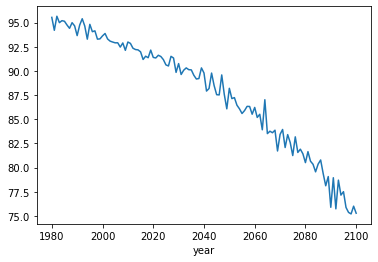

In [98]:
labor_cap = (ds_region_adj*ds_region_adj['capacity']).sum(dim='WBT_bin')
labor_cap = (labor_cap/ds_region_adj.sum(dim='WBT_bin')).mean(dim='ensemble')
labor_cap.plot()